# IESO Demand Projection
## Used for Global Adjustment prediction
This project tries to use RNN to predict the Ontario energy demand.

## Load data and pre-processing

In [2]:
### Load necessary librarys
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import keras

%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

### load in and normalize the dataset
dataset = np.loadtxt('datasets/HourlyDemands.csv')

Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import StandardScaler

def normalize_data(datasets):
    datasets = datasets.reshape(-1, 1)
    scaler = StandardScaler()
    scaler = scaler.fit(datasets)
    standarized = scaler.transform(datasets)
    return standarized

In [4]:
dataset = normalize_data(dataset)

Text(0,0.5,'normalized series value')

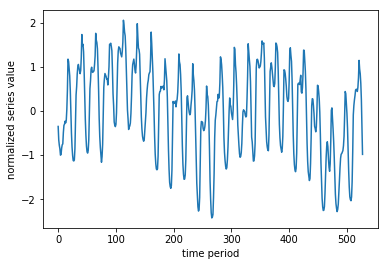

In [5]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

In [6]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # loop for spliting the series into input/output
    for index in range(len(series)-window_size):
        input_ = series[index:index+window_size]
        output_ = series[index+window_size]
        X.append(input_)
        y.append(output_)

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

In [7]:
# window the data using your windowing function
window_size = 24
X,y = window_transform_series(series = dataset,window_size = window_size)

In [8]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [9]:
lstm_size = 24

In [10]:
def build_RNN(window_size, lstm_size):
    # Model initializaiton
    model = Sequential()
    # Add LSTM layers
    # Layer 1
    model.add(LSTM(lstm_size, dropout=0.0, return_sequences=True, recurrent_dropout=0.0, input_shape=(window_size, 1)))
    # Layer 2
    model.add(LSTM(lstm_size, dropout=0.0, recurrent_dropout=0.0))
    # Layer 3
    model.add(Dense(1, activation=None))
    # return
    return model

In [11]:
# Given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)

# Build the model
model = build_RNN(window_size, lstm_size)

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [12]:
# run your model!
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

# save weights
model.save_weights('model_weights/best_RNN_weights.hdf5')

In [13]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [14]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.00230277603536
testing error = 0.113715858687


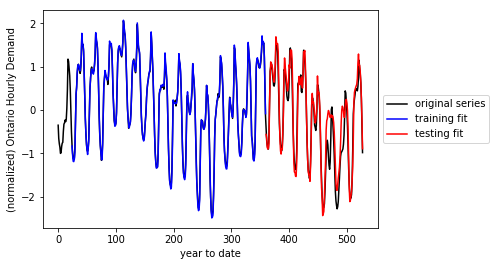

In [15]:
# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('year to date')
plt.ylabel('(normalized) Ontario Hourly Demand')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Real prediction using trained weights

In [16]:
# function that uses trained model to predict a desired number of future characters
def predict_next_demand(model, input_demands, num_of_predict):
    # output
    predicted_demand = []
    # loop through the number of predicts
    for i in range(num_of_predict):
        input_demands = input_demands.reshape((1, window_size, 1))
        # make this round's prediction
        predict_next = model.predict(input_demands,verbose=0)[0]
        # update predicted_chars and input
        predicted_demand.append(predict_next)
        #
        input_demands = np.append(input_demands, predict_next)
        input_demands = input_demands[1:]
        
    return np.asarray(predicted_demand)

In [17]:
# load in weights
model.load_weights('model_weights/best_RNN_weights.hdf5')

start_index = 400
input_demands = dataset[start_index: start_index + window_size]

# use the prediction function
output = predict_next_demand(model,input_demands,num_of_predict = 250)

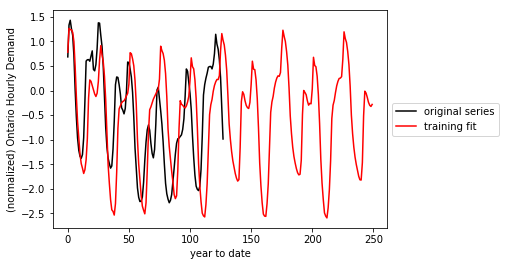

In [18]:
# plot original data
portion_data = dataset[start_index:]
plt.plot(portion_data,color = 'k')

# plot prediction
plt.plot(output,color = 'r')

# pretty up graph
plt.xlabel('year to date')
plt.ylabel('(normalized) Ontario Hourly Demand')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()